In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.feature_selection import RFECV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

random_state=42
random_seed = 42

save_path = 'save_path'
os.chdir(save_path)

X_train_omics_labelled = pd.read_csv("X_train_omics_labelled.csv",index_col=0)
X_test_omics= pd.read_csv("X_test_omics.csv",index_col=0)

train_set_labelled_y= pd.read_csv("train_set_labelled_y.csv",index_col=0)
test_set_labelled_y= pd.read_csv("test_set_labelled_y.csv",index_col=0)

X_valid_omics= pd.read_csv("X_valid_omics.csv",index_col=0)
valid_set_labelled_y= pd.read_csv("valid_set_labelled_y.csv",index_col=0)

save_path2 = '/local/scratch/rp542/data/processed_csv/cv_data'
os.chdir(save_path2)

tv_cv_y = pd.read_csv("tv_cv_y.csv",index_col=0)
X_tv_cv = pd.read_csv("X_tv_cv.csv",index_col=0)

cv_indices = pd.read_csv("cv_indices.csv",index_col=0)

# Recursive Feature Elimination # 

Need to have a CV strategy for this algorithm. We already have defined the train/val split so just use a predifined splitting CV.

In [148]:
tv_cv_y = tv_cv_y.to_numpy().reshape(-1)

In [149]:
cv_indices

,Fold,number_of_elements
0,1,70
1,2,87
2,3,93
3,4,111
4,5,110


Now to define the test_fold, we need to make an array where we set the indicies of the 1st fold to 0, 2nd to 1 etc.

In [150]:
array = np.zeros((70,1))
array2 = np.ones((87,1))
array3 = 2*np.ones((93,1))
array4 = 3*np.ones((111,1))
array5 = 4*np.ones((110,1))
test_fold = np.concatenate((array,array2,array3,array4,array5))
ps = PredefinedSplit(test_fold)

## with Ridge Linear Regression ## 

In [155]:
parameter_grid = {
    "alpha":uniform(290,200)
}

In [156]:
rnd_search = Ridge(solver="cholesky")
random_search_ridge = RandomizedSearchCV(rnd_search, parameter_grid, cv=ps, random_state=random_seed, verbose=1)
random_search_ridge.fit(X_tv_cv,tv_cv_y)
result = pd.concat([pd.DataFrame(random_search_ridge.cv_results_["params"]),pd.DataFrame(random_search_ridge.cv_results_["mean_test_score"], columns=["Score"])],axis=1)
result.sort_values(by="Score", ascending=False, inplace=True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.8s finished


In [157]:
result

,alpha,Score
3,409.731697,0.276148
8,410.223002,0.276147
0,364.908024,0.276127
9,431.614516,0.276096
2,436.398788,0.276080
7,463.235229,0.275965
4,321.203728,0.275886
5,321.198904,0.275886
1,480.142861,0.275872
6,301.616722,0.275684


In [158]:
ridge_reg = Ridge(alpha=409, solver="cholesky",random_state=42)

rfecv = RFECV(estimator=ridge_reg, cv=ps,step=500,scoring="neg_mean_squared_error",verbose=2,n_jobs=1)

In [159]:
rfecv.fit(X_tv_cv,tv_cv_y)

Fitting estimator with 16590 features.
Fitting estimator with 16090 features.
Fitting estimator with 15590 features.
Fitting estimator with 15090 features.
Fitting estimator with 14590 features.
Fitting estimator with 14090 features.
Fitting estimator with 13590 features.
Fitting estimator with 13090 features.
Fitting estimator with 12590 features.
Fitting estimator with 12090 features.
Fitting estimator with 11590 features.
Fitting estimator with 11090 features.
Fitting estimator with 10590 features.
Fitting estimator with 10090 features.
Fitting estimator with 9590 features.
Fitting estimator with 9090 features.
Fitting estimator with 8590 features.
Fitting estimator with 8090 features.
Fitting estimator with 7590 features.
Fitting estimator with 7090 features.
Fitting estimator with 6590 features.
Fitting estimator with 6090 features.
Fitting estimator with 5590 features.
Fitting estimator with 5090 features.
Fitting estimator with 4590 features.
Fitting estimator with 4090 features

RFECV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 4, 4])),
      estimator=Ridge(alpha=409, copy_X=True, fit_intercept=True, max_iter=None,
                      normalize=False, random_state=42, solver='cholesky',
                      tol=0.001),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=500, verbose=2)

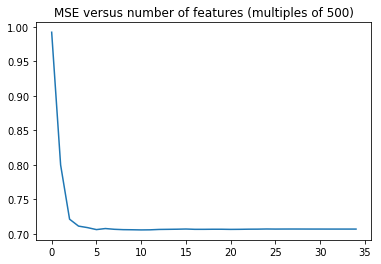

In [160]:
# Plot the RMSE as a function of the number of features
cv_grid_mse = (-rfecv.grid_scores_)

plt.plot(cv_grid_mse)
plt.title('MSE versus number of features (multiples of 500)')
plt.show()

In [161]:
rfecv.n_features_

4590

Let's select the most informative features according to RFECV. We re-run below but using a bigger step size for speed.

In [162]:
X_columns = X_tv_cv.columns

In [163]:
rfecv3 = RFECV(estimator=ridge_reg, cv=ps,step=100,scoring="neg_mean_squared_error",verbose=3,n_jobs=1)
rfecv3.fit(X_tv_cv[X_columns[rfecv.support_]],tv_cv_y)

Fitting estimator with 4590 features.
Fitting estimator with 4490 features.
Fitting estimator with 4390 features.
Fitting estimator with 4290 features.
Fitting estimator with 4190 features.
Fitting estimator with 4090 features.
Fitting estimator with 3990 features.
Fitting estimator with 3890 features.
Fitting estimator with 3790 features.
Fitting estimator with 3690 features.
Fitting estimator with 3590 features.
Fitting estimator with 3490 features.
Fitting estimator with 3390 features.
Fitting estimator with 3290 features.
Fitting estimator with 3190 features.
Fitting estimator with 3090 features.
Fitting estimator with 2990 features.
Fitting estimator with 2890 features.
Fitting estimator with 2790 features.
Fitting estimator with 2690 features.
Fitting estimator with 2590 features.
Fitting estimator with 2490 features.
Fitting estimator with 2390 features.
Fitting estimator with 2290 features.
Fitting estimator with 2190 features.
Fitting estimator with 2090 features.
Fitting esti

Fitting estimator with 590 features.
Fitting estimator with 490 features.
Fitting estimator with 390 features.
Fitting estimator with 290 features.
Fitting estimator with 190 features.
Fitting estimator with 90 features.


RFECV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 4, 4])),
      estimator=Ridge(alpha=409, copy_X=True, fit_intercept=True, max_iter=None,
                      normalize=False, random_state=42, solver='cholesky',
                      tol=0.001),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=100, verbose=3)

In [164]:
rfecv3.n_features_

4590

In [165]:
selected_features_iter_1 = rfecv.support_

In [166]:
ridge_reg.fit(X_tv_cv[X_columns[selected_features_iter_1]],tv_cv_y)
mse(test_set_labelled_y,ridge_reg.predict(X_test_omics[X_columns[selected_features_iter_1]]))

0.854530562580104

In [167]:
r2_score(test_set_labelled_y,ridge_reg.predict(X_test_omics[X_columns[selected_features_iter_1]]))

0.4165839267921828

Using the top 4590 features, we get what will be the best scores. 

Let's see what happens if we reduce features further. Let's see top 1000 features.

First 1000 features seem to account for the greatest drop in MSE on validation set. Let's select them.

In [168]:
ridge_reg.fit(X_tv_cv[X_columns[selected_features_iter_1]],tv_cv_y)

coefficients = np.abs(ridge_reg.coef_)
idx_features = np.argsort(coefficients)[-1000:].reshape(-1)

current_dataframe = X_tv_cv[X_columns[selected_features_iter_1]]
new_dataframe = current_dataframe.iloc[:,idx_features]

In [169]:
ridge_reg.fit(new_dataframe,tv_cv_y)

Ridge(alpha=409, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=42, solver='cholesky', tol=0.001)

Test set

In [170]:
mse(test_set_labelled_y, ridge_reg.predict(X_test_omics[X_columns[selected_features_iter_1]].iloc[:,idx_features]),squared=True)

0.9138938481594703

In [171]:
r2_score(test_set_labelled_y,ridge_reg.predict(X_test_omics[X_columns[selected_features_iter_1]].iloc[:,idx_features]))

0.37605466255983233

## with XGBoost ## 


For a non-linear approach

Random search doesn't make as much sense for this. So many parameters - the parameters that are best on the whole dataset, aren't necessarily best when we train on a smaller subset of features and then test on the valid set. So I use the parameters below which give best val performance when done on 290 features (best as compared to those I get after a random search).

In [172]:
xgb_model = XGBRegressor(tree_method="gpu_hist",objective="reg:squarederror",random_state=random_state,
                            error_score="raise",gamma=1,max_depth=8,min_child_weight=20,n_estimators=80)


xgb_selector = RFECV(estimator=xgb_model, cv=ps,step=1000,scoring="neg_mean_squared_error",verbose=2)

In [173]:
xgb_selector.fit(X_tv_cv,tv_cv_y)

Fitting estimator with 16590 features.
Fitting estimator with 15590 features.
Fitting estimator with 14590 features.
Fitting estimator with 13590 features.
Fitting estimator with 12590 features.
Fitting estimator with 11590 features.
Fitting estimator with 10590 features.
Fitting estimator with 9590 features.
Fitting estimator with 8590 features.
Fitting estimator with 7590 features.
Fitting estimator with 6590 features.
Fitting estimator with 5590 features.
Fitting estimator with 4590 features.
Fitting estimator with 3590 features.
Fitting estimator with 2590 features.
Fitting estimator with 1590 features.
Fitting estimator with 590 features.
Fitting estimator with 16590 features.
Fitting estimator with 15590 features.
Fitting estimator with 14590 features.
Fitting estimator with 13590 features.
Fitting estimator with 12590 features.
Fitting estimator with 11590 features.
Fitting estimator with 10590 features.
Fitting estimator with 9590 features.
Fitting estimator with 8590 features.

RFECV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 4, 4])),
      estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                             colsample_bylevel=1, colsample_bynode=1,
                             colsample_bytree=1, error_score='raise', gamma=1,
                             importance_type='gain', learning_rate=0.1,
                             max_delta_step=0, max_depth=8, min_child_weight=20,
                             missing=None, n_estimators=80, n_jobs=1,
                             nthread=None, objective='reg:squarederror',
                             random_state=42, reg_alpha=0, reg_lambda=1,
                             scale_pos_weight=1, seed=None, silent=None,
                             subsample=1, tree_method='gpu_hist', verbosity=1),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1000, verbose=2)

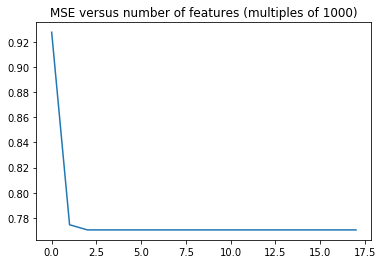

In [174]:
# Plot the RMSE as a function of the number of features
cv_grid_rmse = (-xgb_selector.grid_scores_)

plt.plot(cv_grid_rmse)
plt.title('MSE versus number of features (multiples of 1000)')
plt.show()

In [176]:
#we now rerun but on the top features as selected by xgb_selector
xgb_selector2 = RFECV(estimator=xgb_model, cv=ps,step=100,scoring="neg_mean_squared_error",verbose=2)
xgb_selector2.fit(X_tv_cv[X_columns[xgb_selector.support_]],tv_cv_y)

Fitting estimator with 1590 features.
Fitting estimator with 1490 features.
Fitting estimator with 1390 features.
Fitting estimator with 1290 features.
Fitting estimator with 1190 features.
Fitting estimator with 1090 features.
Fitting estimator with 990 features.
Fitting estimator with 890 features.
Fitting estimator with 790 features.
Fitting estimator with 690 features.
Fitting estimator with 590 features.
Fitting estimator with 490 features.
Fitting estimator with 390 features.
Fitting estimator with 290 features.
Fitting estimator with 190 features.
Fitting estimator with 90 features.
Fitting estimator with 1590 features.
Fitting estimator with 1490 features.
Fitting estimator with 1390 features.
Fitting estimator with 1290 features.
Fitting estimator with 1190 features.
Fitting estimator with 1090 features.
Fitting estimator with 990 features.
Fitting estimator with 890 features.
Fitting estimator with 790 features.
Fitting estimator with 690 features.
Fitting estimator with 590 

RFECV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 4, 4])),
      estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                             colsample_bylevel=1, colsample_bynode=1,
                             colsample_bytree=1, error_score='raise', gamma=1,
                             importance_type='gain', learning_rate=0.1,
                             max_delta_step=0, max_depth=8, min_child_weight=20,
                             missing=None, n_estimators=80, n_jobs=1,
                             nthread=None, objective='reg:squarederror',
                             random_state=42, reg_alpha=0, reg_lambda=1,
                             scale_pos_weight=1, seed=None, silent=None,
                             subsample=1, tree_method='gpu_hist', verbosity=1),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=100, verbose=2)

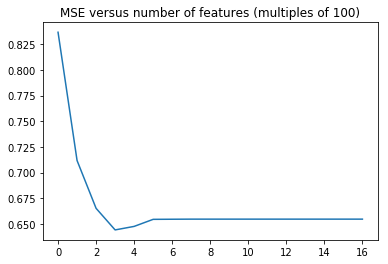

In [179]:
# Plot the RMSE as a function of the number of features
cv_grid_rmse = (-xgb_selector2.grid_scores_)

plt.plot(cv_grid_rmse)
plt.title('MSE versus number of features (multiples of 100)')
plt.show()

In [180]:
xgb_selector2.n_features_
#290 features selected as best

290

In [181]:
features_to_select = X_columns[xgb_selector.support_][xgb_selector2.support_]

In [183]:
xgb_model.fit(X_tv_cv[features_to_select],tv_cv_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, error_score='raise',
             gamma=1, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=8, min_child_weight=20, missing=None,
             n_estimators=80, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, tree_method='gpu_hist', verbosity=1)

**2nd to top scores, with far fewer features required**

In [184]:
mse(test_set_labelled_y, xgb_model.predict(X_test_omics[features_to_select]))

0.8694333440297182

In [185]:
r2_score(test_set_labelled_y,xgb_model.predict(X_test_omics[features_to_select]))

0.4064093085702708

# Lasso L1 Feature Selection # 

In [186]:
lsv = LassoCV(cv=ps,n_jobs=2,random_state=42,n_alphas=10,verbose=3,tol=10**-3)
lsv.fit(X_tv_cv,tv_cv_y)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


(<MemoryView of 'ndarray' at 0x7ff504c2fbe0>, 6.759417442481208e-05, 0.3892365517861, 11)
(<MemoryView of 'ndarray' at 0x7ff504c2fd88>, 7.770694008968348e-05, 0.4100593924231031, 12)
(<MemoryView of 'ndarray' at 0x7ff5072d4048>, 0.010502123865478552, 0.3892365517861, 39)
(<MemoryView of 'ndarray' at 0x7ff5072d41f0>, 0.01528739368211518, 0.4100593924231031, 60)
(<MemoryView of 'ndarray' at 0x7ff5072d4398>, 0.02840506565587475, 0.3892365517861, 108)
(<MemoryView of 'ndarray' at 0x7ff5072d46e8>, 0.028471589123228114, 0.4100593924231031, 118)
(<MemoryView of 'ndarray' at 0x7ff5072d4540>, 0.23197751797113142, 0.3892365517861, 157)
(<MemoryView of 'ndarray' at 0x7ff5072d4890>, 0.372453347240139, 0.4100593924231031, 194)
(<MemoryView of 'ndarray' at 0x7ff5072d4a38>, 0.386730569389087, 0.3892365517861, 478)
(<MemoryView of 'ndarray' at 0x7ff5072d4be0>, 0.40716046704748976, 0.4100593924231031, 312)
(<MemoryView of 'ndarray' at 0x7ff5072d4d88>, 0.38784829745316074, 0.3892365517861, 745)


/home/rp542/venv/lib/python3.5/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9306677505686309, tolerance: 0.4100593924231031
  positive)


(<MemoryView of 'ndarray' at 0x7ff507248048>, 0.9306677505686309, 0.4100593924231031, 1000)
(<MemoryView of 'ndarray' at 0x7ff5072481f0>, 0.38886201434140943, 0.3892365517861, 578)
(<MemoryView of 'ndarray' at 0x7ff507248398>, 0.3875686286843323, 0.3892365517861, 228)
(<MemoryView of 'ndarray' at 0x7ff507248540>, 0.38344773975613355, 0.3892365517861, 70)
(<MemoryView of 'ndarray' at 0x7ff5072486e8>, 0.35034956212338725, 0.3892365517861, 10)
(<MemoryView of 'ndarray' at 0x7ff5072d4d88>, 0.40856565968228953, 0.4100593924231031, 710)
(<MemoryView of 'ndarray' at 0x7ff5072d4540>, 0.0, 0.3600931524317293, 1)
(<MemoryView of 'ndarray' at 0x7ff5072d4a38>, 0.012691077001420581, 0.3600931524317293, 39)
(<MemoryView of 'ndarray' at 0x7ff5072d4048>, 0.40706837744352775, 0.4100593924231031, 224)
(<MemoryView of 'ndarray' at 0x7ff5072d4398>, 0.04076747898170652, 0.3600931524317293, 73)
(<MemoryView of 'ndarray' at 0x7ff504c2fbe0>, 0.408543603135353, 0.4100593924231031, 89)
(<MemoryView of 'ndarray'

/home/rp542/venv/lib/python3.5/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4733350240332861, tolerance: 0.36174716088356457
  positive)


(<MemoryView of 'ndarray' at 0x7ff5072d4890>, 0.4733350240332861, 0.36174716088356457, 1000)
(<MemoryView of 'ndarray' at 0x7ff5072d41f0>, 0.36085223642338304, 0.36174716088356457, 687)
(<MemoryView of 'ndarray' at 0x7ff5072d46e8>, 0.35837641841355694, 0.36174716088356457, 114)
(<MemoryView of 'ndarray' at 0x7ff5072d4d88>, 0.3595681667683893, 0.36174716088356457, 80)
(<MemoryView of 'ndarray' at 0x7ff5072d4048>, 0.3537104303767055, 0.36174716088356457, 8)


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.4min finished


LassoCV(alphas=None, copy_X=True,
        cv=PredefinedSplit(test_fold=array([0, 0, ..., 4, 4])), eps=0.001,
        fit_intercept=True, max_iter=1000, n_alphas=10, n_jobs=2,
        normalize=False, positive=False, precompute='auto', random_state=42,
        selection='cyclic', tol=0.001, verbose=3)

In [187]:
alpha = lsv.alpha_

In [188]:
alpha #best alpha

0.009897663419994051

In [189]:
lasso = Lasso(random_state=42,alpha=alpha,tol=10**-3)

In [190]:
lasso.fit(X_tv_cv,tv_cv_y)

Lasso(alpha=0.009897663419994051, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=42, selection='cyclic', tol=0.001, warm_start=False)

In [191]:
np.unique(lasso.coef_).shape 

(87,)

Lasso regression gives 87 features, giving mse of 0.97 on test set.

In [192]:
mse(test_set_labelled_y,lasso.predict(X_test_omics),squared=True)

0.9701972330232485

In [193]:
r2_score(test_set_labelled_y,lasso.predict(X_test_omics))

0.33761449301650515

# Ridge Regression on whole dataset # 

In [194]:
ridge_reg = Ridge(alpha=409, solver="cholesky",random_state=42)


In [195]:
ridge_reg.fit(X_tv_cv,tv_cv_y)

Ridge(alpha=409, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=42, solver='cholesky', tol=0.001)

In [196]:
mse(test_set_labelled_y,ridge_reg.predict(X_test_omics))

0.8469594009430258

In [197]:
r2_score(test_set_labelled_y,ridge_reg.predict(X_test_omics))

0.42175300743757127

# XGBoost on whole dataset # 

In [198]:
xgreg = XGBRegressor(tree_method="gpu_hist",objective="reg:squarederror",random_state=random_state,
                            error_score="raise",gamma=1,max_depth=8,min_child_weight=20,n_estimators=80) 

In [199]:
xgreg.fit(X_tv_cv,tv_cv_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, error_score='raise',
             gamma=1, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=8, min_child_weight=20, missing=None,
             n_estimators=80, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, tree_method='gpu_hist', verbosity=1)

In [200]:
mse(test_set_labelled_y,xgreg.predict(X_test_omics))

0.853554399236535

In [201]:
r2_score(test_set_labelled_y,xgreg.predict(X_test_omics))

0.4172503855587304

# Save best features # 

In [202]:
features_to_select = features_to_select.to_numpy()

In [203]:
os.chdir(save_path)


In [204]:
np.save("feature_selection.npy",features_to_select,allow_pickle=True)

In [87]:
features = np.load("feature_selection.npy",allow_pickle=True)